<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/tensorflow_supervised_ensemble_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Conv1D, Activation, MaxPooling1D, UpSampling1D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import backend as K

import random as rn
from resource import *
import time
import math
import sys
from collections import Counter

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'

sys.path.append('/content/drive/MyDrive/HAR/')
import wisdm_2_0
# x_train, y_train, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
origianl_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


x_train.shape :  (13913, 200, 3) y_train.shape:  (13913, 6)


In [ ]:
from sklearn.utils import shuffle
def shift(x, y):
    new = []
    for i in range(5):
        temp = np.roll(x, i*40, axis=1)
        new.extend(temp)
    x = np.array(new)
    y = np.concatenate([y]*5)
    x, y = shuffle(x, y, random_state=42)
    return x,y

from scipy.interpolate import CubicSpline
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1))*(np.arange(0, X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])

    cs_x = CubicSpline(xx[:, 0], yy[:, 0])
    cs_y = CubicSpline(xx[:, 1], yy[:, 1])
    cs_z = CubicSpline(xx[:, 2], yy[:, 2])
    return np.array([cs_x(x_range), cs_y(x_range), cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)
    tt_cum = np.cumsum(tt, axis=0)

    t_scale = [(X.shape[0]-1)/tt_cum[-1, 0], (X.shape[0]-1)/tt_cum[-1, 1], (X.shape[0]-1)/tt_cum[-1, 2]]
    tt_cum[:, 0] = tt_cum[:, 0] * t_scale[0]
    tt_cum[:, 1] = tt_cum[:, 1] * t_scale[1]
    tt_cum[:, 2] = tt_cum[:, 2] * t_scale[2]

    return tt_cum

def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])

    X_new[:, 0] = np.interp(x_range, tt_new[:, 0], X[:, 0])
    X_new[:, 1] = np.interp(x_range, tt_new[:, 1], X[:, 1])
    X_new[:, 2] = np.interp(x_range, tt_new[:, 2], X[:, 2])

    return X_new

def TimeWarp(X, Y):
    for i in range(X.shape[0]):
        data = X[i, :, :]
        if i == 0:
            trans_list = DA_TimeWarp(data).reshape(-1, X.shape[1], X.shape[2])
        else:
            trans = DA_TimeWarp(data).reshape(-1, X.shape[1], X.shape[2])
            trans_list = np.concatenate([trans_list, trans], axis=0)

    return trans_list, Y

In [ ]:
def clssifier_without_ae(x_train, y_train, x_val, y_val):
    
    initializer = initializers.GlorotNormal()
    earlystop = EarlyStopping(patience=50, monitor='val_loss', mode='min')
    checkpoint = ModelCheckpoint("SAEwithout.h5", verbose = 0, mode="min", save_best_only=True, save_weights_only = True)
    callbacks_list = [checkpoint ]
    def make_adam(rates = 0.01):
        return keras.optimizers.Adam(learning_rate=rates)

    adam = make_adam()
    inputs = Input(shape=(TIME_PERIODS, N_FEATURES))    
    x = Conv1D(filters=16, kernel_size=3, kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=32, kernel_size=3, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = LSTM(128, kernel_initializer=initializer)(x)
    classified = Dense(num_classes, activation="softmax", name="classified", kernel_initializer=initializer)(x)

    model = Model(inputs, classified)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=300, verbose=1, batch_size = 128, callbacks=callbacks_list, validation_data=(x_val, y_val))
    return history, model

In [ ]:
def build_resnet(input_shape, n_feature_maps, nb_classes):
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv1D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    conv_y = keras.layers.Conv1D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    conv_z = keras.layers.Conv1D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv1D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    x1 = y
    conv_x = keras.layers.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    conv_y = keras.layers.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    conv_z = keras.layers.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)

    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    x1 = y
    conv_x = keras.layers.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    conv_y = keras.layers.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    conv_z = keras.layers.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling1D()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax', name="classified")(full)
    return x, out

In [ ]:
# fix the random seed
# seed_sum = 42
# np.random.seed(seed_sum)
# rn.seed(seed_sum)
# tf.random.set_seed(seed_sum)

TIME_PERIODS = 200
STEP = 200
N_FEATURES = 3


# 80%, 10%, 10%로 set 나누기
x_train, x_val, y_train, y_val = train_test_split(origianl_x, original_y, test_size=0.2, stratify=original_y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

x_timewarp, y_timewarp  = TimeWarp(x_train, y_train)
x_train,    y_train     = shift(x_train, y_train)
x_train = np.concatenate([x_timewarp, x_train], axis=0)
y_train = np.concatenate([y_timewarp, y_train], axis=0)
print("shape of x_train : ", x_train.shape)

# history, model = clssifier_without_ae(x_train, y_train, x_val, y_val)
# model.load_weights("SAEwithout.h5")
# test_results = model.evaluate(x_test, y_test)

x , y = build_resnet((200, 3), 64, 6)
model = keras.models.Model(inputs=x, outputs=y)
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=150, verbose=1, validation_data=(x_val, y_val))

shape of x_train :  (66780, 200, 3)
Merging skip connection
Epoch 1/150
522/522 [==============================] - 25s 41ms/step - loss: 0.5088 - accuracy: 0.7950 - val_loss: 0.4678 - val_accuracy: 0.8009
Epoch 2/150
522/522 [==============================] - 20s 39ms/step - loss: 0.4195 - accuracy: 0.8241 - val_loss: 0.4212 - val_accuracy: 0.8037
Epoch 3/150
522/522 [==============================] - 21s 39ms/step - loss: 0.3759 - accuracy: 0.8401 - val_loss: 0.3916 - val_accuracy: 0.8260
Epoch 4/150
522/522 [==============================] - 21s 39ms/step - loss: 0.3742 - accuracy: 0.8420 - val_loss: 0.4180 - val_accuracy: 0.8181
Epoch 5/150
522/522 [==============================] - 21s 39ms/step - loss: 0.3431 - accuracy: 0.8517 - val_loss: 0.3740 - val_accuracy: 0.8188
Epoch 6/150
522/522 [==============================] - 20s 39ms/step - loss: 0.3289 - accuracy: 0.8572 - val_loss: 0.6624 - val_accuracy: 0.8095
Epoch 7/150
522/522 [==============================] - 21s 39ms/step -

44/44 [==============================] - 1s 8ms/step - loss: 0.5097 - accuracy: 0.8843
maximum train acc :  0.9911201000213623
maximum valid acc :  0.9130122065544128
test acc :  0.8843390941619873
test loss :  0.5097446441650391
f1 score :  0.8458126183240822
[[200   0   0   0   0   0]
 [  0  79   2   1  52   0]
 [  0  16 231   0  68   3]
 [  0   0   0  21   0   1]
 [  0   1  12   0 123   0]
 [  1   0   1   1   2 577]]


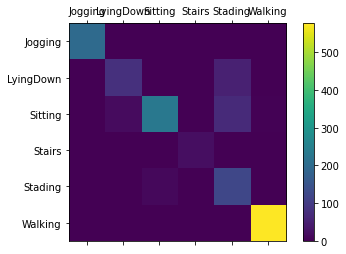

In [ ]:
test_results = model.evaluate([x_test], [y_test, x_test])
print("maximum train acc : ", max(history.history["accuracy"]))
print("maximum valid acc : ", max(history.history["val_accuracy"]))
print("test acc : ", test_results[1])
print("test loss : ", test_results[0])


y_pred = model.predict([x_test])
score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score : ", score)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation="nearest")
fig.colorbar(cax)
ax.set_xticklabels(['']+label)
ax.set_yticklabels(['']+label)
plt.show()